# Petfinder Adoption Prediction


<b>Author: </b> Dawid Wisniewski

<b>Goal of the project:</b> The goal of the project is to predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder site. 

<b>Data:</b> The data included text, tabular, and image data. See below for details.

<b>Project description and data:</b> https://www.kaggle.com/c/petfinder-adoption-prediction

<b>Date: </b> 2020-04-10

# 0. Import libraries

In [1]:
# File manipulation and caggle
import os
from kaggle.api.kaggle_api_extended import KaggleApi #requires 
import zipfile
import json

# Data manipulation
import pandas as pd
import numpy as np

# Picture handling
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image

# Charts
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data preprocessing
from sklearn.model_selection import train_test_split

# Modeling


Note that the above requires Kaggle token on your system:
1. Log-in to Kaggle (or sign up)
2. Navigate to your Account page (click top-right profile picture)
3. Scroll down to the API section and click Create New API Token
4. Save kaggle.json to the file path displayed in the OSError message given when attempting to import kaggle

#  <font color='green'> Hint </font>
## <font color='green'> You can skip right to step [1.4.3](#skipped_processing) to avoid processing the original raw files and save ~30 minutes </font>

# 1. Data imports

## 1.0 Download all data from kaggle - <font color='red'>WATCH OUT - Run this only once</font>
Once you download the data for the project, you should not run those cells any more


In [5]:
# Get current dir

current_dir = os.getcwd()
data_dir = current_dir+r'/Data'
data_dir

'/home/dawid/Python/Kodolamacz/Projekt/pet_adoption/Data'

In [6]:

# Download the data from kaggle

competition_name = 'petfinder-adoption-prediction'

kaggle_api = KaggleApi()
kaggle_api.authenticate()
kaggle_api.competition_download_files(competition_name, path=data_dir)

NameError: name 'kaggle' is not defined

In [ ]:
# Unzip the files

data_zip_file = f'{data_dir}/{competition_name}.zip'

with zipfile.ZipFile(data_zip_file, 'r') as zipref:
    zipref.extractall(data_dir)

In [ ]:
# Remove the zip file to save space

os.remove(data_zip_file) 

The data from kaggle is already divided into train and test. 
Data is difided into 3 folders:
- train (or test) tabularized data in train folder
- train (or test) images in train_images folder
- train (or test) metadata - data received from processing the imagess via Google Vision Api in train_metadata folder
- train (or test) metadata - data received from processing the descriptions via Google's Natural Language API in train_sentiment folder
- some additional label data are available in separate CSVs:
        breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
        color_labels.csv - Contains ColorName for each ColorID
        state_labels.csv - Contains StateName for each StateID

## 1.1 Import data descriptions

### 1.1.1 Breeds

In [2]:
breed_labels = pd.read_csv('Data/breed_labels.csv')
breed_labels

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita
...,...,...,...
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van


In [3]:
breed_labels_dict = {}
for i in breed_labels.index:
    breed_labels_dict[breed_labels.BreedID[i]] = breed_labels.BreedName[i]
breed_labels_dict

{1: 'Affenpinscher',
 2: 'Afghan Hound',
 3: 'Airedale Terrier',
 4: 'Akbash',
 5: 'Akita',
 6: 'Alaskan Malamute',
 7: 'American Bulldog',
 8: 'American Eskimo Dog',
 9: 'American Hairless Terrier',
 10: 'American Staffordshire Terrier',
 11: 'American Water Spaniel',
 12: 'Anatolian Shepherd',
 13: 'Appenzell Mountain Dog',
 14: 'Australian Cattle Dog/Blue Heeler',
 15: 'Australian Kelpie',
 16: 'Australian Shepherd',
 17: 'Australian Terrier',
 18: 'Basenji',
 19: 'Basset Hound',
 20: 'Beagle',
 21: 'Bearded Collie',
 22: 'Beauceron',
 23: 'Bedlington Terrier',
 24: 'Belgian Shepherd Dog Sheepdog',
 25: 'Belgian Shepherd Laekenois',
 26: 'Belgian Shepherd Malinois',
 27: 'Belgian Shepherd Tervuren',
 28: 'Bernese Mountain Dog',
 29: 'Bichon Frise',
 30: 'Black and Tan Coonhound',
 31: 'Black Labrador Retriever',
 32: 'Black Mouth Cur',
 33: 'Black Russian Terrier',
 34: 'Bloodhound',
 35: 'Blue Lacy',
 36: 'Bluetick Coonhound',
 37: 'Boerboel',
 38: 'Bolognese',
 39: 'Border Collie'

### 1.1.2 Fur colors

In [4]:
color_labels = pd.read_csv('Data/color_labels.csv')
color_labels

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


In [5]:
color_dict = {}
for i in color_labels.index:
    color_dict[color_labels.ColorID[i]] = color_labels.ColorName[i]
color_dict

{1: 'Black',
 2: 'Brown',
 3: 'Golden',
 4: 'Yellow',
 5: 'Cream',
 6: 'Gray',
 7: 'White'}

### 1.1.3 State labels

In [6]:
state_labels = pd.read_csv('Data/state_labels.csv')
state_labels

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


In [6]:
state_labels_dict = {}
for i in state_labels.index:
    state_labels_dict[state_labels.StateID[i]] = state_labels.StateName[i]
state_labels_dict

NameError: name 'state_labels' is not defined

### 1.1.4 Other labels
Labels from project data description

In [7]:
type_dict = {1: 'Dog', 2: 'Cat'}
gender_dict = {1: 'Male', 2: 'Female', 3: 'Mixed'}
maturity_size_dict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large', 0: 'Not Specified'}
fur_length_dict = {1: 'Short', 2: 'Medium, 3 = Long', 0: 'Not Specified'}
vaccinated_dict = {1: 'Yes', 2: 'No', 3: 'Not Sure'}
dewormed_dict = {1: 'Yes', 2: 'No', 3: 'Not Sure'}
sterilized_dict = {1: 'Yes', 2: 'No', 3: 'Not Sure'}
health_dict = {1: 'Healthy', 2: 'Minor Injury', 3: 'Serious Injury', 0: 'Not Specified'}

## 1.2 Import the main data and look at it

### 1.2.1 The tabularized data

#### Let's create a function for future import for train and test

In [8]:
def import_tabularized_data(dataset: str) -> pd.DataFrame:
    print('Starting import of tabularized data')
    data = pd.read_csv(f'Data/{dataset}/{dataset}.csv')
    print('Import of tabularized data complete')
    print('----------------------------------------------')
    return data

In [9]:
data = import_tabularized_data('train')
data

Starting import of tabularized data
Import of tabularized data complete
----------------------------------------------


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,1,4,0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,2
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,1,2,0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,4
14990,2,Monkies,2,265,266,3,5,6,7,3,...,1,5,30,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,3
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,1,1,0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,4


In [20]:
data.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

#### Data Fields (description from Kaggle)

- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


### 1.2.2 Description sentiment from Google Natural Language API

#### Sentiment Data (from project description)

We have run each pet profile's description through Google's Natural Language API, providing analysis on sentiment and key entities. You may optionally utilize this supplementary information for your pet description analysis. There are some descriptions that the API could not analyze. As such, there are fewer sentiment files than there are rows in the dataset.

File name format is PetID.json.

Google Natural Language API reference: https://cloud.google.com/natural-language/docs/basics

In [9]:
# First let's have a look at an example of description analyzed via Google 
# Natural Language API

data[data.PetID=='0a0e8c15b'].Description

5290    Fenny was rescued from Old Klang Rd market whe...
Name: Description, dtype: object

In [10]:
# Now let's see how a json file with sentiment is structuredl

with open('Data/train_sentiment/0a0e8c15b.json') as json_file:
    sentiment_file = json.load(json_file)
    
sentiment_file

{'sentences': [{'text': {'content': 'Fenny was rescued from Old Klang Rd market when she was only 2 months old and I have fostered her since then.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.1, 'score': -0.1}},
  {'text': {'content': 'She is 5 mths old now and I hope she can get a good home.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.7, 'score': 0.7}},
  {'text': {'content': 'She looks like a mixed breed of local mongrel and Dalmation.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.1, 'score': 0.1}},
  {'text': {'content': 'She is a very quiet girl and does not make too much noise, that makes her a very good companion for children or elderly couple.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0.9, 'score': 0.9}},
  {'text': {'content': 'Please call Mrs Lai of Paws Mission for more adoption details.',
    'beginOffset': -1},
   'sentiment': {'magnitude': 0, 'score': 0}}],
 'tokens': [],
 'entities': [{'name': 'Fenny',
   'type': 'PERSO

#### Observations:
* As minimum we will use the overal 'documentSentiment' considering the score, the magnitude or mix of both 
(consider finding minimum thresholds for positive and nevative scores)
* Furthermore let's see how the results per sentence looks like, and if it is potentially also worth adding

In [17]:
# Let's look at the sentiment data for sentences in one description

for sentence in sentiment_file['sentences']:
    print(sentence['sentiment'])

{'magnitude': 0.4, 'score': 0.4}
{'magnitude': 0.5, 'score': 0.5}
{'magnitude': 0.1, 'score': -0.1}


#### Observations:
-  at sentence level it seems that absolute value of score is the same as magnitude, so it's only useful to track score
- note that the number of sentences will vary so we are not planning to save score for each sentence, rather aggregates like minimum, maximum and mean
- additionally at this stage it's easy to save the number of sentences

#### The plan for handling the data:
Now once we know what data we want to extract from each file:
- the overal 'documentSentiment' considering the score, the magnitude and the mix of both
- score for each sentence will be used in aggregate (min, max, mean, sum)
- we will extrac this data from all files and save in a dataframe

In [10]:
def import_sentiment_data(dataset: str, tabularized_data: pd.DataFrame) -> pd.DataFrame:
    print('Starting import of sentiment data')
    # Get the interesting sentiment data from json files
    sentence_data=[]
    missing_files = 0
    for file in tabularized_data.PetID:
        try:
            with open(f'Data/{dataset}_sentiment/{file}.json') as json_file:
                sentiment_file = json.load(json_file)

            sentiment = sentiment_file['documentSentiment']['score']
            magnitude = sentiment_file['documentSentiment']['magnitude']
            combined_sentiment = sentiment * magnitude

            sentence_scores = [sentence['sentiment']['score'] 
                               for sentence in sentiment_file['sentences']]
            number_of_sentences = len(sentence_scores)

            avg_sentence_score = np.mean(sentence_scores)
            min_sentence_score = np.min(sentence_scores)
            max_sentence_score = np.max(sentence_scores)
            sum_sentence_score = np.sum(sentence_scores)

            sentence_data.append([file, sentiment, magnitude, combined_sentiment, 
                                 number_of_sentences, avg_sentence_score, 
                                  min_sentence_score, max_sentence_score, 
                                  sum_sentence_score])

        except:
            missing_files += 1

    sentence_data = pd.DataFrame(sentence_data, columns=['PetID', 'sentiment', 'magnitude', 
                            'combined_sentiment', 'number_of_sentences', 
                            'avg_sentence_score', 'min_sentence_score', 
                            'max_sentence_score', 'sum_sentence_score'])

    if missing_files:
        print(f'Sentiment files for {missing_files} pets was missing')

    print('Import of sentiment data complete')
    print('----------------------------------------------')
    return sentence_data


In [12]:
sentence_data = import_sentiment_data('train', data)

Starting import of sentiment data
Sentiment files for 551 pets was missing
Import of sentiment data complete
----------------------------------------------


In [13]:
sentence_data

,PetID,sentiment,magnitude,combined_sentiment,number_of_sentences,avg_sentence_score,min_sentence_score,max_sentence_score,sum_sentence_score
0,86e1089a3,0.3,2.4,0.72,6,0.300000,-0.2,0.8,1.8
1,6296e909a,-0.2,0.7,-0.14,2,-0.250000,-0.6,0.1,-0.5
2,3422e4906,0.2,3.7,0.74,7,0.200000,-0.9,0.9,1.4
3,5842f1ff5,0.9,0.9,0.81,1,0.900000,0.9,0.9,0.9
4,850a43f90,0.6,3.7,2.22,6,0.583333,0.0,0.8,3.5
...,...,...,...,...,...,...,...,...,...
14437,dc0935a84,0.4,2.5,1.00,6,0.400000,0.0,0.9,2.4
14438,a01ab5b30,0.0,0.3,0.00,3,0.100000,0.0,0.2,0.3
14439,d981b6395,0.8,2.5,2.00,3,0.833333,0.7,0.9,2.5
14440,e4da1c9e4,0.9,0.9,0.81,1,0.900000,0.9,0.9,0.9


### 1.2.3 Photo description from Google Vision

#### Image Metadata (from project description)

We have run the images through Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. You may optionally utilize this supplementary information for your image analysis.

File name format is PetID-ImageNumber.json.

Some properties will not exist in JSON file if not present, i.e. Face Annotation. Text Annotation has been simplified to just 1 entry of the entire text description (instead of the detailed JSON result broken down by individual characters and words). Phone numbers and emails are already anonymized in Text Annotation.

Google Vision API reference: https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate

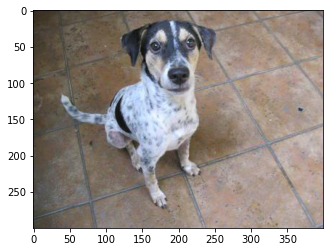

In [15]:
# Let's see an example of a picture
img = mpimg.imread('Data/train_images/0a0e8c15b-1.jpg')
plt.imshow(img)
plt.show()

In [45]:
# Let's check how many pictures are available per photo
data.PhotoAmt.value_counts()

1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
6.0      621
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
11.0     184
12.0      97
13.0      86
14.0      78
15.0      50
16.0      39
17.0      27
20.0      25
19.0      20
30.0      19
18.0      18
21.0      16
24.0      15
23.0      12
26.0      10
22.0       9
25.0       8
28.0       7
27.0       6
29.0       6
Name: PhotoAmt, dtype: int64

#### Observation: 
Since there are multiple pictures per pet, but there are many pets that do not have morethan one, we will analyze only the first one (which is the "profile picture" anyway.

In [22]:
# Let's see the Google Vision output for this picture
with open('Data/train_metadata/0a0e8c15b-1.json') as json_file:
    metadata = json.load(json_file)
    
metadata

{'labelAnnotations': [{'mid': '/m/0kpmf',
   'description': 'dog breed',
   'score': 0.94287944,
   'topicality': 0.94287944},
  {'mid': '/m/0bt9lr',
   'description': 'dog',
   'score': 0.9390443,
   'topicality': 0.9390443},
  {'mid': '/m/01z5f',
   'description': 'dog like mammal',
   'score': 0.85380834,
   'topicality': 0.85380834},
  {'mid': '/m/0ysvz',
   'description': 'louisiana catahoula leopard dog',
   'score': 0.8262601,
   'topicality': 0.8262601},
  {'mid': '/m/05zmzn1',
   'description': 'street dog',
   'score': 0.79076236,
   'topicality': 0.79076236},
  {'mid': '/m/02xl47d',
   'description': 'dog breed group',
   'score': 0.6743105,
   'topicality': 0.6743105},
  {'mid': '/m/08c5h8',
   'description': 'brazilian terrier',
   'score': 0.6140104,
   'topicality': 0.6140104},
  {'mid': '/m/0bh41s',
   'description': 'feist',
   'score': 0.59842026,
   'topicality': 0.59842026},
  {'mid': '/m/01lrl',
   'description': 'carnivoran',
   'score': 0.5740566,
   'topicality'

#### Observations:
* Consider using similarity to other dog breeds (identified by Google's Vision might be useful on top of the actual breed)
* Consider using Dominant colors might also have impact on AdoptionSpeed
* Consider using the cropping hints as an indicator of picture framing

In [11]:
def import_metadata_data(dataset: str, tabularized_data: pd.DataFrame) -> pd.DataFrame:

    print('Starting import of metadata data')
    #helpful function to "transpose" data into one row per dataset
    def rows_to_columns(data: pd.DataFrame, id_column_name: str, id_value: str) -> pd.DataFrame:
        column_names=[f'{column_name}_{row_number}' for row_number in np.arange(data.shape[0])
                for column_name in data.columns]
        values = data.to_numpy().flatten()
        data_flat = pd.DataFrame([values], columns=column_names)
        data_flat[id_column_name]= id_value
        return data_flat
    
    #get metadata

    missing_files = 0
    color_data = pd.DataFrame()
    breeds_data = pd.DataFrame()
    cropping_area_data = pd.DataFrame()
    for i, pet in enumerate(tabularized_data.PetID):
        if tabularized_data[tabularized_data.PetID==pet].PhotoAmt.values[0] > 0:
            file = f'{pet}-{1}'

            with open(f'Data/{dataset}_metadata/{file}.json') as json_file:
                metadata_file = json.load(json_file)

            # processing potential breeds
            try:
                potential_breeds = pd.DataFrame([element for element in 
                                    metadata_file['labelAnnotations']]).drop(['mid', 'topicality'], axis=1)
                potential_breeds_flat = rows_to_columns(potential_breeds, 'PetID', pet)
                potential_breeds_flat['full_description'] = potential_breeds.description.str.cat(sep=";")
                breeds_data = pd.concat([breeds_data, potential_breeds_flat]).reset_index(drop=True)
            except:
                print(f'No descriptions for PetID: {pet}')

            # processing colors
            try:
                dominant_colors = pd.DataFrame([color_set['color'] for color_set in 
                                   metadata_file['imagePropertiesAnnotation']['dominantColors']['colors']])
                dominant_colors['color_pixel_share'] = [score['pixelFraction'] for score in 
                                    metadata_file['imagePropertiesAnnotation']['dominantColors']['colors']]
                dominant_colors = dominant_colors.sort_values('color_pixel_share', ascending=False).reset_index(drop=True)
                # transform into one row with multiple colors
                dominant_colors_flat = rows_to_columns(dominant_colors, 'PetID', pet)
                color_data = pd.concat([color_data, dominant_colors_flat]).reset_index(drop=True)
            except:
                print(f'No color information for PetID: {pet}')                

            # processing cropping area
            x, y = [], []
            try:      
                for coordinates in metadata_file['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices']:
                        x.append(coordinates.get('x',0))
                        y.append(coordinates.get('y',0))
                cropping_area_flat = pd.DataFrame([(x[0], y[0], x[2], y[2])], columns=['main_picture_x_start', 'main_picture_y_start',
                                                  'main_picture_x_end', 'main_picture_y_end'])
                cropping_area_flat['PetID']= pet
                cropping_area_data = pd.concat([cropping_area_data, cropping_area_flat]).reset_index(drop=True)
            except:
                print(f'No cropping area information for PetID: {pet}')                
            if i % 1000 == 0:
                print("%d json files already processed" % i)

        else:
            missing_files += 1

    if missing_files:
        print(f'Metadata files for {missing_files} pets was missing')

    # combine all 3 elements into one data file
    metadata_data= breeds_data.merge(color_data, on='PetID', how='outer')
    metadata_data= metadata_data.merge(cropping_area_data, on='PetID', how='outer')
    print('Import of metadata data complete')
    print('----------------------------------------------')
    return metadata_data

In [12]:
metadata_data = import_metadata_data('train', data)

Starting import of metadata data
0 json files already processed
1000 json files already processed
2000 json files already processed
3000 json files already processed
4000 json files already processed
5000 json files already processed
No descriptions for PetID: a977f3331
6000 json files already processed
7000 json files already processed
8000 json files already processed
9000 json files already processed
10000 json files already processed
11000 json files already processed
12000 json files already processed
No descriptions for PetID: dd4b67059
13000 json files already processed
14000 json files already processed
Metadata files for 341 pets was missing
Import of metadata data complete
----------------------------------------------


In [16]:
metadata_data

,description_0,score_0,description_1,score_1,description_2,score_2,description_3,score_3,description_4,score_4,...,blue_8,color_pixel_share_8,red_9,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end
0,cat,0.990786,black cat,0.956530,small to medium sized cats,0.919535,cat like mammal,0.894983,bombay,0.853989,...,47.0,0.000320,126.0,23.0,53.0,0.000080,0,0,359,479
1,cat,0.981269,whiskers,0.905297,small to medium sized cats,0.891908,fauna,0.841606,cat like mammal,0.834615,...,18.0,0.014682,17.0,32.0,18.0,0.011993,0,0,398,376
2,dog,0.960457,dog like mammal,0.941660,dog breed,0.941017,dog breed group,0.903123,miniature fox terrier,0.737992,...,51.0,0.001301,108.0,83.0,80.0,0.001127,0,0,299,399
3,dog,0.978698,dog like mammal,0.946035,dog breed,0.938040,dog breed group,0.874950,puppy,0.858104,...,104.0,0.005550,103.0,98.0,130.0,0.000087,0,0,399,299
4,dog,0.984346,dog like mammal,0.965755,dog breed,0.942495,puppy,0.932304,mammal,0.924393,...,141.0,0.012032,74.0,44.0,30.0,0.002807,0,0,517,426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,cat,0.954626,small to medium sized cats,0.881990,dog breed group,0.845515,cat like mammal,0.814097,whiskers,0.747402,...,18.0,0.004316,185.0,180.0,174.0,0.002797,0,0,359,479
14648,cat,0.993517,small to medium sized cats,0.925218,cat like mammal,0.912557,fauna,0.892146,whiskers,0.814101,...,17.0,0.005723,80.0,50.0,23.0,0.004856,0,0,299,399
14649,dog,0.977956,dog like mammal,0.957780,puppy,0.939893,dog breed,0.939205,dog breed group,0.848722,...,45.0,0.002580,157.0,67.0,14.0,0.002391,43,0,639,541
14650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,0.000260,70.0,51.0,53.0,0.000173,23,0,319,298


### 1.2.4 Image data

#### Observation
- On top of the image itself, image size might have an impact on adoption speed

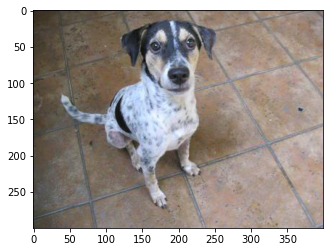

In [46]:
# Let's see an example of a picture
img = mpimg.imread('Data/train_images/0a0e8c15b-1.jpg')
plt.imshow(img)
plt.show()

In [13]:
def import_images_data(dataset: str, tabularized_data: pd.DataFrame) -> (pd.DataFrame, np.ndarray):
    print('Starting import of pictures data')
    
    folder = f"Data/{dataset}_images"
    
    #let's first get the list of files to get
    missing_files = 0
    files = []
    for pet in tabularized_data.PetID:
        if tabularized_data[tabularized_data.PetID==pet].PhotoAmt.values[0] > 0:
            files.append(pet)
        else:
            missing_files += 1
    print(f"Working with {len(files)} images")
    if missing_files:
        print(f'Images for {missing_files} pets were missing')

    # Most popular Dimensions
    image_width = 400
    image_height = 300
    channels = 3

    images = np.ndarray(shape=(len(files), channels, image_height, image_width),
                         dtype=np.float32)
    shapes = []

    for i, pet in enumerate(files):
        file = f'{pet}-{1}.jpg'
        try:
            img = load_img(folder + "/" + file)  # this is a PIL image
            # let's also save the origina; dimensions of each picture 
            shape = list(img.size)
            shape.append(pet)
            shapes.append(shape)
            #resize the image
            img = img.resize((image_width, image_height))
            # Convert to Numpy Array
            x = img_to_array(img)  
            x = x.reshape((channels, image_height, image_width))
            # Scale
            #x = x / 256.0
            images[i] = x
            if i % 1000 == 0:
                print("%d images already in array" % i)
        except:
            print(f'No image for PetID: {pet}')

    print(f"All {i+1} images in array!")

    shapes_data = pd.DataFrame(shapes, columns =['width','height','PetID'])
    shapes_data['dimensions'] = shapes_data.width.map(str)+"x"+shapes_data.height.map(str)
    
    print('Import of pictures data complete')
    print('----------------------------------------------')
    return shapes_data, images

In [7]:
shapes_data, images = import_images_data('train', data)

Starting import of pictures data
Working with 14652 images
Images for 341 pets were missing
0 images already in array
1000 images already in array
2000 images already in array
3000 images already in array
4000 images already in array
5000 images already in array
6000 images already in array
7000 images already in array
8000 images already in array
9000 images already in array
10000 images already in array
11000 images already in array
12000 images already in array
13000 images already in array
14000 images already in array
All 14652 images in array!
Import of pictures data complete
----------------------------------------------


In [8]:
shapes_data

,width,height,PetID,dimensions
0,360,480,86e1089a3,360x480
1,399,377,6296e909a,399x377
2,300,400,3422e4906,300x400
3,400,300,5842f1ff5,400x300
4,640,427,850a43f90,640x427
...,...,...,...,...
14647,360,480,dc0935a84,360x480
14648,300,400,a01ab5b30,300x400
14649,360,480,d981b6395,360x480
14650,300,400,e4da1c9e4,300x400


In [9]:
#checking the most popular image size
shapes_data['dimensions'].value_counts()

400x300    2736
360x480    1903
300x400    1501
640x480     932
270x480     744
           ... 
255x400       1
320x268       1
640x445       1
376x480       1
639x475       1
Name: dimensions, Length: 1318, dtype: int64

## 1.3 Create the full data sets

### 1.3.1 All data except images

#### Merging data from all datasets except for image data

In [287]:
data_no_image = data.merge(sentence_data, how='left', on='PetID')
data_no_image = data_no_image.merge(metadata_data, how='left', on='PetID')
data_no_image = data_no_image.merge(shapes_data, how='left', on='PetID')
data_no_image 

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end,width,height,dimensions
0,2,Nibble,3,299,0,1,1,7,0,1,...,23.0,53.0,0.000080,0.0,0.0,359.0,479.0,360.0,480.0,300x400
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,32.0,18.0,0.011993,0.0,0.0,398.0,376.0,399.0,377.0,360x480
2,1,Brisco,1,307,0,1,2,7,0,2,...,83.0,80.0,0.001127,0.0,0.0,299.0,399.0,300.0,400.0,300x400
3,1,Miko,4,307,0,2,1,2,0,2,...,98.0,130.0,0.000087,0.0,0.0,399.0,299.0,400.0,300.0,266x400
4,1,Hunter,1,307,0,1,1,0,0,2,...,44.0,30.0,0.002807,0.0,0.0,517.0,426.0,640.0,427.0,640x478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,40.0,38.0,0.000719,0.0,0.0,359.0,479.0,360.0,480.0,640x480
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,33.0,18.0,0.001648,0.0,0.0,299.0,399.0,300.0,400.0,640x360
14990,2,Monkies,2,265,266,3,5,6,7,3,...,180.0,174.0,0.002797,0.0,0.0,359.0,479.0,360.0,480.0,640x426
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,50.0,23.0,0.004856,0.0,0.0,299.0,399.0,300.0,400.0,640x427


#### Adding labels from dictionaries

In [17]:
def recode_variables_with_dictionaries(data: pd.DataFrame) -> pd.DataFrame:
    # Recoding
    data.Breed1 = data.Breed1.apply(lambda x: breed_labels_dict.get(x, 'na'))
    data.Breed2 = data.Breed1.apply(lambda x: breed_labels_dict.get(x, 'na'))
    
    data.Color1 = data.Color1.apply(lambda x: color_dict.get(x, 'na'))
    data.Color2 = data.Color2.apply(lambda x: color_dict.get(x, 'na'))
    data.Color3 = data.Color3.apply(lambda x: color_dict.get(x, 'na'))

    data.Type = data.Type.apply(lambda x: type_dict.get(x, 'na'))
    data.Gender = data.Gender.apply(lambda x: gender_dict.get(x, 'na'))
    data.MaturitySize = data.MaturitySize.apply(lambda x: maturity_size_dict.get(x, 'na'))
    data.FurLength = data.FurLength.apply(lambda x: fur_length_dict.get(x, 'na'))
    data.Vaccinated = data.Vaccinated.apply(lambda x: vaccinated_dict.get(x, 'na'))
    data.Dewormed = data.Dewormed.apply(lambda x: dewormed_dict.get(x, 'na'))
    data.Sterilized = data.Sterilized.apply(lambda x: sterilized_dict.get(x, 'na'))
    data.Health = data.Health.apply(lambda x: health_dict.get(x, 'na'))
    return data

In [ ]:
data_no_image = recode_variables_with_dictionaries(data_no_image)

In [292]:
data_no_image

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end,width,height,dimensions
0,Cat,Nibble,3,Tabby,na,Male,Black,White,na,Small,...,23.0,53.0,0.000080,0.0,0.0,359.0,479.0,360.0,480.0,300x400
1,Cat,No Name Yet,1,Domestic Medium Hair,na,Male,Black,Brown,na,Medium,...,32.0,18.0,0.011993,0.0,0.0,398.0,376.0,399.0,377.0,360x480
2,Dog,Brisco,1,Mixed Breed,na,Male,Brown,White,na,Medium,...,83.0,80.0,0.001127,0.0,0.0,299.0,399.0,300.0,400.0,300x400
3,Dog,Miko,4,Mixed Breed,na,Female,Black,Brown,na,Medium,...,98.0,130.0,0.000087,0.0,0.0,399.0,299.0,400.0,300.0,266x400
4,Dog,Hunter,1,Mixed Breed,na,Male,Black,na,na,Medium,...,44.0,30.0,0.002807,0.0,0.0,517.0,426.0,640.0,427.0,640x478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,Cat,NaN,2,Domestic Short Hair,na,Mixed,Black,na,na,Medium,...,40.0,38.0,0.000719,0.0,0.0,359.0,479.0,360.0,480.0,640x480
14989,Cat,Serato & Eddie,60,Domestic Medium Hair,na,Mixed,Black,Yellow,White,Medium,...,33.0,18.0,0.001648,0.0,0.0,299.0,399.0,300.0,400.0,640x360
14990,Cat,Monkies,2,Domestic Medium Hair,na,Mixed,Cream,Gray,White,Large,...,180.0,174.0,0.002797,0.0,0.0,359.0,479.0,360.0,480.0,640x426
14991,Cat,Ms Daym,9,Domestic Short Hair,na,Female,Yellow,White,na,Small,...,50.0,23.0,0.004856,0.0,0.0,299.0,399.0,300.0,400.0,640x427


### 1.3.2 All data except images

In [295]:
data_with_image = shapes_data.merge(data, how='left', on='PetID')
data_with_image = data_with_image.merge(sentence_data, how='left', on='PetID')
data_with_image = data_with_image.merge(metadata_data, how='left', on='PetID')
data_with_image 

,width,height,PetID,dimensions,Type,Name,Age,Breed1,Breed2,Gender,...,blue_8,color_pixel_share_8,red_9,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end
0,360,480,86e1089a3,300x400,2,Nibble,3,299,0,1,...,47.0,0.000320,126.0,23.0,53.0,0.000080,0,0,359,479
1,399,377,6296e909a,360x480,2,No Name Yet,1,265,0,1,...,18.0,0.014682,17.0,32.0,18.0,0.011993,0,0,398,376
2,300,400,3422e4906,300x400,1,Brisco,1,307,0,1,...,51.0,0.001301,108.0,83.0,80.0,0.001127,0,0,299,399
3,400,300,5842f1ff5,266x400,1,Miko,4,307,0,2,...,104.0,0.005550,103.0,98.0,130.0,0.000087,0,0,399,299
4,640,427,850a43f90,640x478,1,Hunter,1,307,0,1,...,141.0,0.012032,74.0,44.0,30.0,0.002807,0,0,517,426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,360,480,dc0935a84,640x480,2,NaN,2,266,0,3,...,15.0,0.001439,67.0,40.0,38.0,0.000719,0,0,359,479
14648,300,400,a01ab5b30,640x360,2,Serato & Eddie,60,265,264,3,...,165.0,0.003295,32.0,33.0,18.0,0.001648,0,0,299,399
14649,360,480,d981b6395,640x426,2,Monkies,2,265,266,3,...,18.0,0.004316,185.0,180.0,174.0,0.002797,0,0,359,479
14650,300,400,e4da1c9e4,640x427,2,Ms Daym,9,266,0,2,...,17.0,0.005723,80.0,50.0,23.0,0.004856,0,0,299,399


#### Note for future
For picture processing we will need to combine the values of data_with_image with images but it's better to do it after handling NAs and feature engineering

# 1.4 Compiling data

Let's create functions for easier import of both train and test datasets.
Note that for modeling we will only use the original train data and split it into train and test. We will use the original test data for ultimate test.

### 1.4.1 Importing all data from the original train and test sets

In [16]:
def import_and_merge_data(dataset: str) -> (pd.DataFrame, pd.DataFrame, np.ndarray):
    # Import all datasets
    data = import_tabularized_data(dataset) 
    sentence_data = import_sentiment_data(dataset, data) 
    metadata_data = import_metadata_data(dataset, data) 
    shapes_data, images = import_images_data(dataset, data) 
    
    # Main data set, without pictures
    data_no_image = data.merge(sentence_data, how='left', on='PetID')
    data_no_image = data_no_image.merge(metadata_data, how='left', on='PetID')
    data_no_image = data_no_image.merge(shapes_data, how='left', on='PetID')
    print('Mereging data complete')
    print('----------------------------------------------')
    
    # Recode
    data_no_image = recode_variables_with_dictionaries(data_no_image)
    print('Recoding data complete')
    print('----------------------------------------------')
    
    # Merge data that has images available
    data_with_image = shapes_data.merge(data, how='left', on='PetID')
    data_with_image = data_with_image.merge(sentence_data, how='left', on='PetID')
    data_with_image = data_with_image.merge(metadata_data, how='left', on='PetID')
    print('Mereging picture data complete')
    print('----------------------------------------------')
    
    return data_no_image, data_with_image, images

#### Now get the original train and test data

In [18]:
train, train_with_image, train_images= import_and_merge_data('train')

Starting import of tabularized data
Import of tabularized data complete
----------------------------------------------
Starting import of sentiment data
Sentiment files for 551 pets was missing
Import of sentiment data complete
----------------------------------------------
Starting import of metadata data
0 json files already processed
1000 json files already processed
2000 json files already processed
3000 json files already processed
4000 json files already processed
5000 json files already processed
No descriptions for PetID: a977f3331
6000 json files already processed
7000 json files already processed
8000 json files already processed
9000 json files already processed
10000 json files already processed
11000 json files already processed
12000 json files already processed
No descriptions for PetID: dd4b67059
13000 json files already processed
14000 json files already processed
Metadata files for 341 pets was missing
Import of metadata data complete
---------------------------------

In [19]:
final_test, final_test_with_image, final_test_images = import_and_merge_data('test')

Starting import of tabularized data
Import of tabularized data complete
----------------------------------------------
Starting import of sentiment data
Sentiment files for 107 pets was missing
Import of sentiment data complete
----------------------------------------------
Starting import of metadata data
0 json files already processed
1000 json files already processed
2000 json files already processed
No descriptions for PetID: 3dc3877f0
3000 json files already processed
Metadata files for 114 pets was missing
Import of metadata data complete
----------------------------------------------
Starting import of pictures data
Working with 3858 images
Images for 114 pets were missing
0 images already in array
1000 images already in array
2000 images already in array
3000 images already in array
All 3858 images in array!
Import of pictures data complete
----------------------------------------------
Mereging data complete
----------------------------------------------
Recoding data complete

### 1.4.2 Saving data <font color='green'> [optional] </font>
This step is done to save data processing time for future analyses

#### Creating folder to save the files if it does not exist already

In [32]:
folder = "Processed_data"
folder_exists = os.path.isdir(folder)
if not folder_exists:
    os.mkdir(folder)

#### Processing pictures so they can be saved in file

In [35]:
train_images.shape

(14652, 3, 300, 400)

In [27]:
# for saving image data we need to convert it to 2d array so we need to know the dimensions
image_size = train_images.shape[1]* train_images.shape[2]* train_images.shape[3]
image_size

360000

In [31]:
#reshaping the image
train_images_to_save = train_images.reshape(-1,image_size)
final_test_images_to_save = final_test_images.reshape(-1,image_size)
train_images_to_save.shape, final_test_images_to_save.shape

((14652, 360000), (3858, 360000))

#### Saving files

In [34]:
train.to_csv(f'{folder}/train.csv')
train_with_image.to_csv(f'{folder}/train_with_image.csv')
np.savetxt(f'{folder}/train_images.txt', train_images_to_save)
final_test.to_csv(f'{folder}/final_test.csv')
final_test_with_image.to_csv(f'{folder}/final_test_with_image.csv')
np.savetxt(f'{folder}/final_test_images.txt', final_test_images_to_save)

<a id='skipped_processing'></a>
<br><br><br><br>

# <font color='green'> If you skip the data processing, you should start here </font>

### 1.4.3 Importing compiled datasets <font color='green'> [optional if all steps 1.2-1.4.1 were run] </font>
This step is done to save data processing time for future analyses

#### Main data

In [2]:
folder = "Processed_data"
train = pd.read_csv(f'{folder}/train.csv').drop('Unnamed: 0', axis=1) #the file has the old indexes in the first column
final_test = pd.read_csv(f'{folder}/final_test.csv').drop('Unnamed: 0', axis=1) #the file has the old indexes in the first column

#### Pictures data
Note that since there are many pictures, almost 40GB, loading them takes a few minutes <br>
Note that the images are integers (to save disk space) so need to scale them later

In [ ]:
train_with_image = pd.read_csv(f'{folder}/train_with_image.csv')
train_images = np.loadtxt(f'{folder}/train_images.txt')

final_test_with_image = pd.read_csv(f'{folder}/final_test_with_image.csv')
final_test_images = np.loadtxt(f'{folder}/final_test_images.txt')

## 1.5 Train test split
In the future sections, the original train data will be devided into the train and test data. <br>
The original test data will be used as the final validation of the final model, and will be referred to as final_test.

In [3]:
y = train['AdoptionSpeed']
X = train.drop('AdoptionSpeed', axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123, stratify=y)

# 2. Data Exploration

## 2.1 The dependent variable

In [15]:
pd.DataFrame({'count': y_train.value_counts(), 'freq': y_train.value_counts(normalize=True)})

,count,freq
4,3357,0.279890
2,3230,0.269301
3,2607,0.217359
1,2472,0.206103
0,328,0.027347


* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

The number of pets adopted in 0 days is so small that we should group them with category 1. This way the data in all categories will be balanced. Furthermore the ability to identify the few profiles that lead to adoption in the same day does not seem crucial

In [14]:
y.dtypes

dtype('int64')

## 2.2 Independent variables

### 2.2.1 General information on the data

In [21]:
X_train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end,width,height,dimensions
1888,Dog,Wolfe,72,German Shepherd Dog,na,Male,Brown,Golden,Yellow,Medium,...,139.0,172.0,0.004788,0.0,0.0,308.0,399.0,309.0,400.0,309x400
723,Dog,Save Me Or I'll Die #20,12,Mixed Breed,na,Male,Black,Brown,Cream,Medium,...,179.0,211.0,0.003692,0.0,0.0,266.0,399.0,267.0,400.0,267x400
4694,Dog,Brownie,24,Mixed Breed,na,Male,Black,Brown,na,Medium,...,34.0,37.0,0.000087,0.0,0.0,299.0,399.0,300.0,400.0,300x400
4940,Cat,Boboy,1,Domestic Short Hair,na,Male,Gray,White,na,Small,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9214,Dog,"Olaf, Lyn And Little White",3,Mixed Breed,na,Mixed,Black,Brown,Golden,Medium,...,234.0,211.0,0.027411,0.0,0.0,359.0,479.0,360.0,480.0,360x480


We should notice that even categorical variable might have missing information which is not classified as missing. Example: Breed2 where na is string, but the information is missing (This information is provided only if the pet is of mixed breed.

Let's have a closer look at mixed breed dogs later, but we can see already that:
- it might be useful to add additional variable to classify as mixed breed
- some mixed breed animals have Mixed Breed in Bread1

Let's try to understand what information is behind Gender - Mixed

Let's also have a closer look at colors later, missing information is marked as na (Color 3)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11994 entries, 1888 to 13092
Data columns (total 99 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Type                  11994 non-null  object 
 1   Name                  10997 non-null  object 
 2   Age                   11994 non-null  int64  
 3   Breed1                11994 non-null  object 
 4   Breed2                11994 non-null  object 
 5   Gender                11994 non-null  object 
 6   Color1                11994 non-null  object 
 7   Color2                11994 non-null  object 
 8   Color3                11994 non-null  object 
 9   MaturitySize          11994 non-null  object 
 10  FurLength             11994 non-null  object 
 11  Vaccinated            11994 non-null  object 
 12  Dewormed              11994 non-null  object 
 13  Sterilized            11994 non-null  object 
 14  Health                11994 non-null  object 
 15  Quantity        

Majority of the columns are numeric. <br>
Let's start looking at the categorical variables first. <br>
With numeric variable there are is a lot of missing information for many variables so let's decide what to do with it

### 2.2.2 Non-numeric columns

In [47]:
non_numeric_columns = X_train.select_dtypes(exclude=np.number).columns
non_numeric_columns

Index(['Type', 'Name', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'RescuerID', 'Description', 'PetID',
       'description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'full_description', 'description_9', 'dimensions'],
      dtype='object')

In [39]:
len(non_numeric_columns)

29

#### Let's have a closer look at columns with very many categories

In [46]:
many_categories = 20

In [56]:
total_rows = X_train.shape[0]
for column in non_numeric_columns:
    number_of_unique_categories = len(X_train[column].unique())
    if number_of_unique_categories >= many_categories:
        print(f'Column: {column}')
        all_values=X_train[column]
        nan_values = X_train[column].isna().sum()
        na_values = (X_train[column]=="na").sum()
        all_missing = nan_values + na_values 
        print(f'All values: {total_rows - all_missing} out of {total_rows}. ({all_missing/total_rows:.2%} are missing)')
        print(f'Number of missing values: {nan_values}')
        print(f'Number of "na" values: {na_values}')
        print(f'Unique values: {number_of_unique_categories}')
        print(pd.DataFrame({'count': X_train[column].value_counts(), 'freq': X_train[column].value_counts(normalize=True)}))
        print('---------------------------------------------------------------')

Column: Name
All values: 10997 out of 11994. (8.31% are missing)
Number of missing values: 997
Number of "na" values: 0
Unique values: 7470
                                     count      freq
Lucky                                   54  0.004910
Baby                                    50  0.004547
Brownie                                 46  0.004183
No Name                                 45  0.004092
Blackie                                 44  0.004001
...                                    ...       ...
Urgent :3 Cute Kittens For Adoption      1  0.000091
Putera And Puteri                        1  0.000091
Long Hair Calico                         1  0.000091
Beeny                                    1  0.000091
Kriss                                    1  0.000091

[7469 rows x 2 columns]
---------------------------------------------------------------
Column: Breed1
All values: 11990 out of 11994. (0.03% are missing)
Number of missing values: 0
Number of "na" values: 4
Unique values: 

         count      freq
400x300   2202  0.187868
360x480   1525  0.130108
300x400   1202  0.102551
640x480    760  0.064841
270x480    570  0.048631
...        ...       ...
480x384      1  0.000085
400x349      1  0.000085
640x547      1  0.000085
232x385      1  0.000085
640x359      1  0.000085

[1171 rows x 2 columns]
---------------------------------------------------------------


Column observations:
* Name - recode into binary - there is a huge number of variants, even the most popular variant is less than 1%. The only useful information seems to be if there is any => create has_name variable 1- not nan, 0 - nan
* Breed 1 - analyze further for grouping of breeds (below)
* RescuerID - drop from analysis - since this information is hashed, it should not have any impact on AdoptionSpeed

#### Breed1

Let's look at top breeds for Dogs and Cats separately

In [12]:
X_train[X_train['Type']=='Dog']['Breed1'].value_counts(normalize=True).head(20)

Mixed Breed             0.727567
Labrador Retriever      0.025902
Shih Tzu                0.023127
Poodle                  0.020814
Terrier                 0.018810
Golden Retriever        0.017730
German Shepherd Dog     0.012643
Rottweiler              0.012026
Spitz                   0.011255
Beagle                  0.011101
Miniature Pinscher      0.009097
Schnauzer               0.008634
Jack Russell Terrier    0.008326
Doberman Pinscher       0.007709
Husky                   0.005088
Dalmatian               0.004625
Chihuahua               0.004471
Cocker Spaniel          0.004163
Border Collie           0.003854
Dachshund               0.003700
Name: Breed1, dtype: float64

In [13]:
X_train[X_train['Type']=='Cat']['Breed1'].value_counts(normalize=True).head(20)

Domestic Short Hair     0.532680
Domestic Medium Hair    0.179194
Tabby                   0.051380
Domestic Long Hair      0.042484
Siamese                 0.039216
Persian                 0.031227
Calico                  0.015977
American Shorthair      0.014706
Oriental Short Hair     0.010712
Bengal                  0.010530
Tuxedo                  0.008533
Maine Coon              0.005447
Tortoiseshell           0.005265
Russian Blue            0.004357
British Shorthair       0.004357
Abyssinian              0.003813
Tiger                   0.003450
Bobtail                 0.002905
Burmese                 0.002905
Oriental Long Hair      0.002723
Name: Breed1, dtype: float64

Let's also see the 4 values classified as na

In [14]:
X_train[X_train['Breed1']=='na']

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,green_9,blue_9,color_pixel_share_9,main_picture_x_start,main_picture_y_start,main_picture_x_end,main_picture_y_end,width,height,dimensions
1045,Dog,Bella 4 Months Puppy!,4,na,na,Female,Brown,Golden,na,Medium,...,101.0,82.0,0.007432,0.0,0.0,359.0,479.0,360.0,480.0,360x480
7285,Dog,"""Boy Boy""",72,na,na,Male,Black,Brown,na,Medium,...,157.0,76.0,0.004004,0.0,0.0,339.0,479.0,340.0,480.0,340x480
3219,Cat,NaN,3,na,na,Mixed,Black,Yellow,White,Small,...,17.0,20.0,0.005645,0.0,0.0,399.0,224.0,400.0,225.0,400x225
7706,Dog,Looking Newborn Puppy For Adoption,2,na,na,Female,Brown,Cream,White,Small,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Breed 1 - let's recode into <br>
for cats: Domestic Short Hair Cat, Domestic Medium and Long Hair Cat, Purebred Cat <br>
for dogs: Mixed Breed Dog, Purebred Dog <br>
'na' - replace with dominant category pre-recoding, i.e. Domestic Short Hair Cat or Mixed Breed Dog

Breed1 vs Breed2

#### Let's have a closer look at columns with a limited number of categories

Column: Type
Unique values: 2


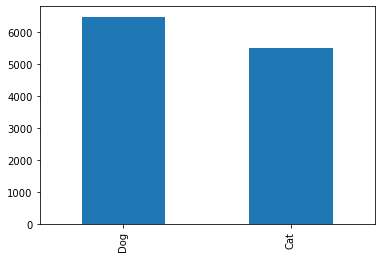

Column: Name
Unique values: 7470


/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 158 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWar

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 140 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 155 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyp

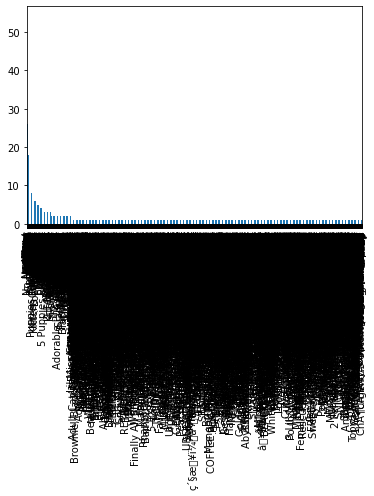

Column: Breed1
Unique values: 170


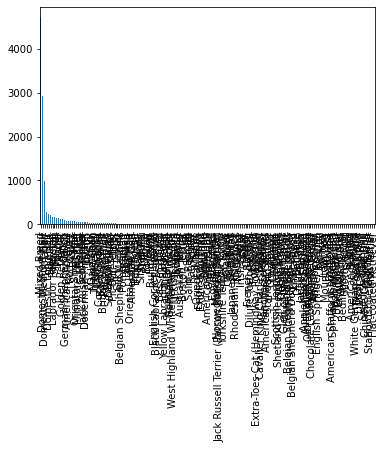

Column: Breed2
Unique values: 1


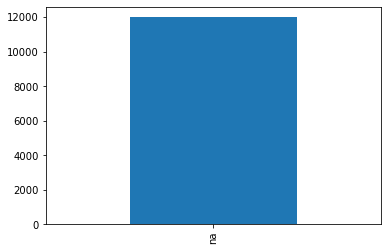

Column: Gender
Unique values: 3


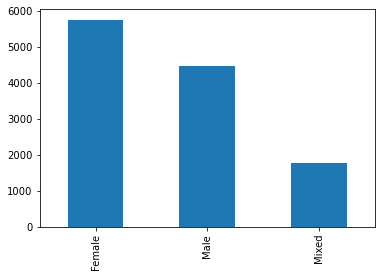

Column: Color1
Unique values: 7


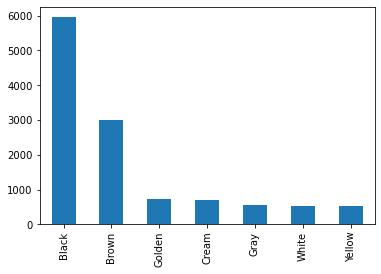

Column: Color2
Unique values: 7


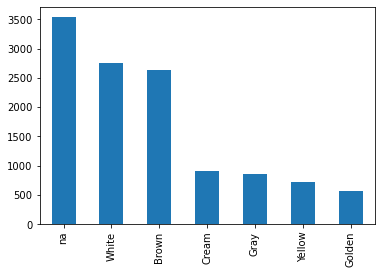

Column: Color3
Unique values: 6


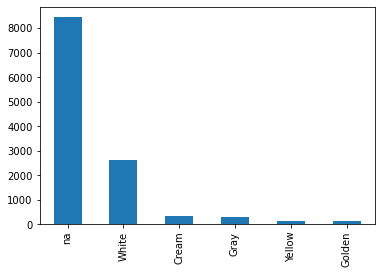

Column: MaturitySize
Unique values: 4


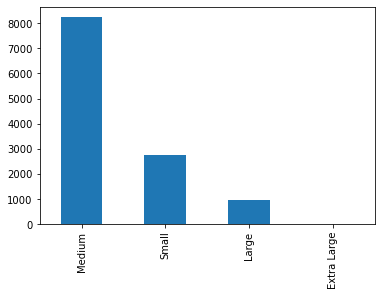

Column: FurLength
Unique values: 3


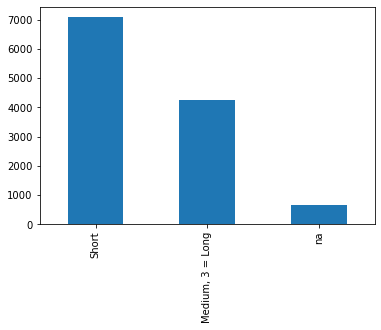

Column: Vaccinated
Unique values: 3


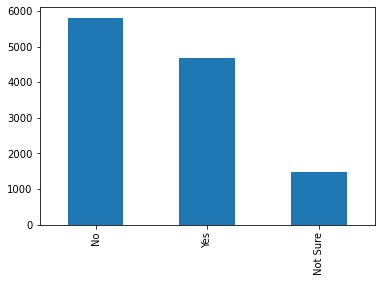

Column: Dewormed
Unique values: 3


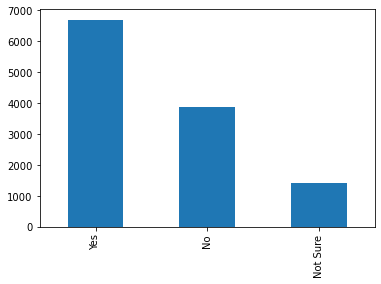

Column: Sterilized
Unique values: 3


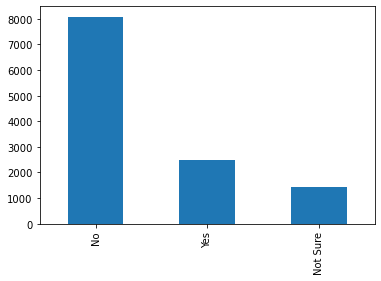

Column: Health
Unique values: 3


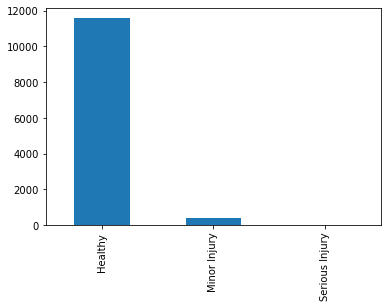

Column: RescuerID
Unique values: 4800


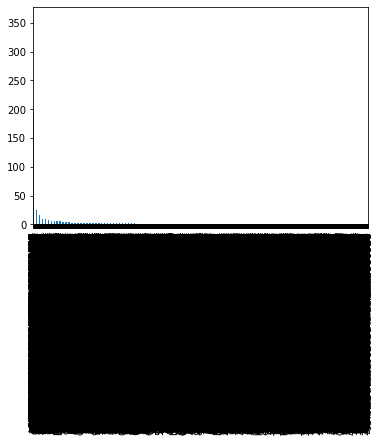

Column: Description
Unique values: 11293


/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20182 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127969 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29483 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214:

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32321 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24537 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24609 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20445 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36947 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32418 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20572 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36554 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29702 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20061 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38957 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25812 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36935 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128054 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65349 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65348 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:21

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37096 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32959 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30244 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27915 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33905 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35961 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32441 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30721 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20184 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20474 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65295 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26114 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25925 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20107 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31199 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23458 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27490 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32422 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 40857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23429 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127880 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26106 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29926 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20943 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22266 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 61516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28155 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22495 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36719 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32974 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dawid/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: 

KeyboardInterrupt: 

In [42]:
for column in non_numeric_columns:
    number_of_unique_categories = len(X_train[column].unique())
    if number_of_unique_categories < many_categories:
        print(f'Column: {column}')
        print(f'Unique values: {len(X_train[column].unique())}')
        X_train[column].value_counts().plot.bar()
        plt.show()

### 2.2.3 Numeric columns

In [37]:
numeric_columns = X_train.select_dtypes(include=np.number).columns
numeric_columns

Index(['Age', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'sentiment',
       'magnitude', 'combined_sentiment', 'number_of_sentences',
       'avg_sentence_score', 'min_sentence_score', 'max_sentence_score',
       'sum_sentence_score', 'score_0', 'score_1', 'score_2', 'score_3',
       'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9',
       'red_0', 'green_0', 'blue_0', 'color_pixel_share_0', 'red_1', 'green_1',
       'blue_1', 'color_pixel_share_1', 'red_2', 'green_2', 'blue_2',
       'color_pixel_share_2', 'red_3', 'green_3', 'blue_3',
       'color_pixel_share_3', 'red_4', 'green_4', 'blue_4',
       'color_pixel_share_4', 'red_5', 'green_5', 'blue_5',
       'color_pixel_share_5', 'red_6', 'green_6', 'blue_6',
       'color_pixel_share_6', 'red_7', 'green_7', 'blue_7',
       'color_pixel_share_7', 'red_8', 'green_8', 'blue_8',
       'color_pixel_share_8', 'red_9', 'green_9', 'blue_9',
       'color_pixel_share_9', 'main_picture_x_start', 'main_picture

In [35]:
X_train.describe().shape

(8, 70)

In [34]:
X_train.describe().iloc[:,0:10]

,Age,Quantity,Fee,State,VideoAmt,PhotoAmt,sentiment,magnitude,combined_sentiment,number_of_sentences
count,11994.000000,11994.000000,11994.000000,11994.000000,11994.000000,11994.000000,11557.000000,11557.000000,11557.000000,11557.000000
mean,10.393113,1.592880,21.048191,41346.042521,0.059530,3.902118,0.279207,2.144493,0.613088,5.164056
std,18.168297,1.511043,79.132164,32.441817,0.361987,3.483916,0.276652,2.070145,0.760286,4.891900
min,0.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,-0.900000,0.000000,-1.890000,1.000000
25%,2.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,0.100000,0.800000,0.040000,2.000000
50%,3.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,0.200000,1.700000,0.420000,4.000000
75%,11.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,0.400000,2.800000,0.850000,7.000000
max,255.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,0.900000,32.000000,9.100000,84.000000


# 3. Data Cleaning

## 3.1 Missing values

## 3.2 Outlier values

### w liście Rona 3.3. to Skalowanie danych

### w liście Rona 3.4. to Redukcja danych?

### w liście Rona 3.5. to Feature Engineering

### u Rona 3.6 coding categorical variables - czy to tu czy w Feature engineering

# 4. Feature Engiineering

# 5. Scaling

# Training model

# Validating the model

# Model interpretation